# Autoregressive models

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import pickle
import os

import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid

Use the following functions to train your models.

In [ ]:
def get_cross_entropy_loss(model, x):
    return F.cross_entropy(model(x), x)
    
def train_epoch(model, train_loader, optimizer, device):
    model.train()
  
    train_losses = []
    for x in train_loader:
        x = x.to(device)
        loss = get_cross_entropy_loss(model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device)
            loss = get_cross_entropy_loss(model, x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_model(model, train_loader, test_loader, epochs, lr, device):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_model(model, test_loader, device)]
    for epoch in range(epochs):
        model.train()
        train_losses.extend(train_epoch(model, train_loader, optimizer, device))
        test_loss = eval_model(model, test_loader, device)
        test_losses.append(test_loss)

    return train_losses, test_losses

## Task 1 (3 points): 1D histogram

In this task you should train histogram model on discrete 1D data.

In [ ]:
def generate_1d_data(count, bins):
    np.random.seed(42)
    a = 0.2 + 0.05 * np.random.randn(count)
    b = 0.6 + 0.15 * np.random.randn(count)
    mask = np.random.rand(count) < 0.5
    samples = (a * mask + b * (1 - mask)) * (bins - 1)
    data = np.clip(samples.astype('int'), 0.0, (bins - 1))
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data


def plot_1d_data(train_data, test_data):
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title('train')
    ax1.hist(train_data, bins=bins, density=True)
    ax1.set_xlabel('x')
    ax2.set_title('test')
    ax2.hist(test_data, bins=np.arange(bins), density=True)
    plt.show()
    
    
def plot_training_curves(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title('training curves')
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    
    
def plot_1d_distribution(data, distribution):
    size = len(distribution)

    plt.figure(figsize=(8, 6))
    plt.hist(data, bins=np.arange(size) - 0.5, label='train data', density=True)

    x = np.linspace(-0.5, size - 0.5, 1000)
    y = distribution.repeat(1000 // size)
    plt.plot(x, y, label='learned distribution')

    plt.title('learned distribution')
    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.legend()

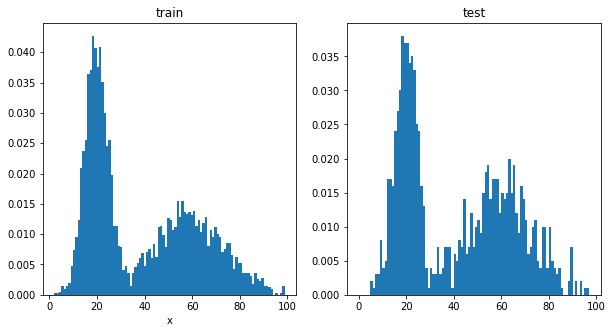

In [ ]:
BINS = 100
COUNT = 5000

train_data, test_data = generate_1d_data(COUNT, BINS)
train_data = train_data.astype('int')
test_data = test_data.astype('int')
plot_1d_data(train_data, test_data)

Let $\theta = (\theta_0, \dots, \theta_{d}) \in \mathbb{R}^{d}$ are model parameters. Your model is a softmax function: $p(k| \theta) = \frac{e^{\theta_k}}{\sum_{l=1}^d e^{\theta_{l}}}$.

The goal is to train $p(k| \theta)$ using maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. 

In [ ]:
class SoftmaxModel(nn.Module):
    def __init__(self, bins):
        super().__init__()
        self.bins = bins
        self.logits = nn.Parameter(torch.zeros(bins))

    def forward(self, x):
        return torch.stack([self.logits] * x.shape[0], 0)
        
        
def get_distribution(model):
    return F.softmax(model.logits, dim=0).detach().cpu().numpy()

In [ ]:
# check that your model outputs right shape
model = SoftmaxModel(BINS)
assert [10, BINS] == list(model(torch.rand((10,))).size())

In [ ]:
# you have to choose these parameters by yourself
BATCH_SIZE = 250
EPOCHS = 100
LR = 0.01
device = torch.device('cuda:0') if torch.cuda.is_available() else  torch.device('cpu')

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, device=device)

# check that your loss is not too large
assert test_losses[-1] < 4.25

In [ ]:
distribution = get_distribution(model)

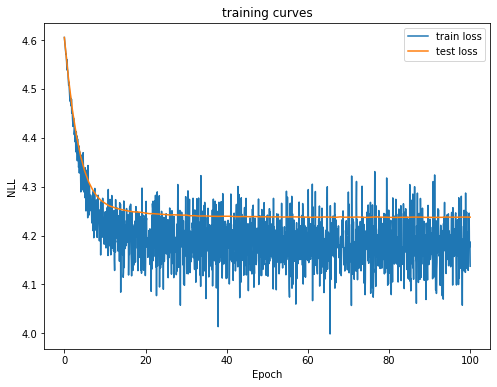

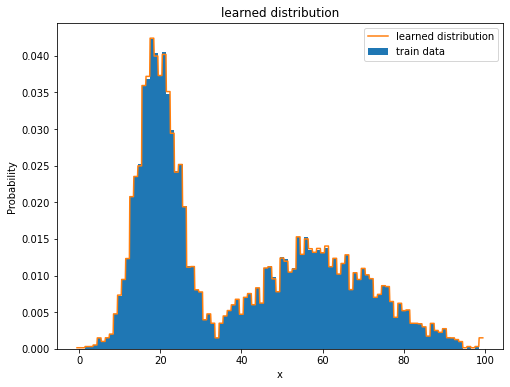

In [ ]:
distribution = get_distribution(model)

# check that function get_distribution works correctly
assert isinstance(distribution, np.ndarray)
assert distribution.shape == (BINS,)

plot_training_curves(train_losses, test_losses)
plot_1d_distribution(train_data, distribution)

## Task 2 (5 points): MADE on 2d data

Train MADE model on single image (https://arxiv.org/abs/1502.03509).

You will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, \text{n_bins}\}$. Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given image, with any autoregressive ordering of your choosing ($p(x_0, x_1) = p(x_0)p(x_1 | x_0)$ or $p(x_0, x_1) = p(x_1)p(x_0 | x_1)$). We advice you first of all think about what conditional dictribution you want to fit and how MADE's masks should look like. It may be useful to one-hot encode your inputs.

You do not have to change these functions (except the path to the data file, download it from here: https://drive.google.com/file/d/1GUthJrA5fBpvi593Swo36t8zaFw9Dyak/view?usp=sharing

In [ ]:
def generate_2d_data(count, bins):
    # change the path to the image
    im = Image.open(
        'dgm.png'
    ).resize((bins, bins)).convert('L')
    im = np.array(im).astype('float32')
    dist = im / im.sum()

    pairs = list(itertools.product(range(bins), range(bins)))
    idxs = np.random.choice(len(pairs), size=count, replace=True, p=dist.reshape(-1))
    samples = np.array([pairs[i] for i in idxs])

    split = int(0.8 * len(samples))
    return dist, samples[:split], samples[split:]


def plot_2d_data(train_data, test_data):
    bins = int(max(test_data.max(), train_data.max()) - min(test_data.min(), train_data.min())) + 1
    train_dist, test_dist = np.zeros((bins, bins)), np.zeros((bins, bins))
    for i in range(len(train_data)):
        train_dist[train_data[i][0], train_data[i][1]] += 1
    train_dist /= train_dist.sum()

    for i in range(len(test_data)):
        test_dist[test_data[i][0], test_data[i][1]] += 1
    test_dist /= test_dist.sum()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    ax1.set_title('Train Data')
    ax1.imshow(train_dist, cmap='gray')
    ax1.axis('off')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x0')

    ax2.set_title('Test Data')
    ax2.imshow(test_dist, cmap='gray')
    ax2.axis('off')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x0')

    plt.show()
    
    
def plot_2d_distribution(true_dist, learned_dist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.imshow(true_dist, cmap='gray')
    ax1.set_title('True Distribution')
    ax1.axis('off')
    ax2.imshow(learned_dist, cmap='gray')
    ax2.set_title('Learned Distribution')
    ax2.axis('off')

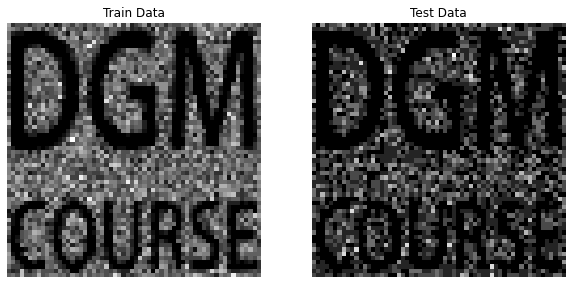

In [ ]:
COUNT = 20000
BINS = 60

image, train_data, test_data = generate_2d_data(COUNT, BINS)
plot_2d_data(train_data, test_data)

In [ ]:
train_data = torch.LongTensor(train_data)
test_data = torch.LongTensor(test_data)

In [ ]:
def to_one_hot(labels, d):
    # one hot encoding
    one_hot = torch.FloatTensor(labels.shape[0], labels.shape[1], d).to(labels.device)
    one_hot.zero_()
    one_hot.scatter_(2, labels.unsqueeze(2), 1)
    return one_hot


class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

    
class MADE(nn.Module):
    def __init__(self, nin, bins, hidden_sizes):
        super().__init__()
        self.nin = nin
        self.nout = nin * bins
        self.bins = bins
        self.hidden_sizes = hidden_sizes
        # we will use the trivial ordering of input units
        self.ordering = np.arange(self.nin) + 1

        # define a simple MLP neural net
        # you can define a list of modules (fc + relu) and stack it using nn.Sequential
        self.net = []
        prev_size = nin * bins
        for size in hidden_sizes:
            self.net.append(MaskedLinear(prev_size, size))
            self.net.append(nn.ReLU())
            prev_size = size

        self.net.append(MaskedLinear(prev_size, self.nout))
        self.net = nn.Sequential(*self.net)

        self.create_mask()  # builds the initial self.m connectivity

        
    def create_mask(self):
        self.masks = []
        prev_ord = self.ordering.repeat(self.bins)[None, :]
        for size in self.hidden_sizes:
            if self.nin > 2:
                next_ord = np.random.randint(1, self.nin - 1, size)[:, None]
            else:
                next_ord = np.ones((size, 1))
            mask = np.where(prev_ord <= next_ord, 1, 0).T
            prev_ord = next_ord.T
            self.masks.append(mask)

        next_ord = np.concatenate([self.ordering] * self.bins)[:, None]     
        mask = np.where(prev_ord < next_ord, 1, 0).T
        self.masks.append(mask)

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, self.masks):
            l.set_mask(m)

    def visualize_masks(self):
        for m in self.masks:
            plt.figure(figsize=(5, 5))
            plt.imshow(m, cmap='gray')
            plt.show()

    def forward(self, x):
        # your code (do not forget to use one hot encoding)
        x = to_one_hot(x, self.bins).view(x.shape[0], -1)
        x = self.net(x)
        return x.view(x.shape[0], self.bins, -1)


    def sample(self, n, device=torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')):
        xs = []
        self.to(device)
        for _ in range(n):
            # generate random object
            x = torch.randint(0, self.bins, (1, self.nin)).to(device)
            for it in range(self.nin):
                # autoregressive generation is sequential
                # generate probs to the generated sample
                probs = F.softmax(self.forward(x)[0, :, it], dim=0)
                distr = torch.distributions.categorical.Categorical(probs)
                # assign the sampled component to the corresponding element of the x
                x[0, it] = distr.sample()
            xs.append(x)
        xs = torch.cat(xs)
        return xs.cpu().numpy()


def get_distribution(model, device=torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')):
    # returns an array BINS x BINS with probabilities of each pixel
    # you have to generate grid of all possible image positions,
    # take the model output for this grid
    # take the corresponding elements of the output tensor
    # reshape if to the square matrrix
    grid = np.hstack(
        [
         np.concatenate([np.arange(model.bins)] * model.bins)[:, None],
         np.repeat(np.arange(model.bins), model.bins)[:, None]
        ]
    )
    grid = torch.LongTensor(grid).to(device)
    model = model.to(device)
    probes = F.softmax(model(grid), 1)
    return (torch.gather(probes[:, :, 0], 1, grid[:, 0].unsqueeze(1)) * \
           torch.gather(probes[:, :, 1], 1, grid[:, 1].unsqueeze(1))).view(
               model.bins,
               model.bins
           ).transpose(0, 1).cpu().detach().numpy()

In [ ]:
HIDDEN_SIZES = [240, 240]

model = MADE(2, BINS, HIDDEN_SIZES)
assert [10, 60, 2] == list(model(torch.randint(0, BINS, (10, 2))).size())

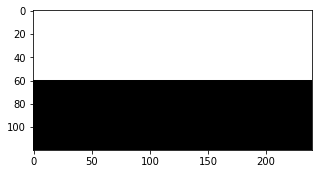

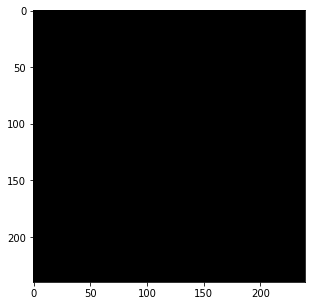

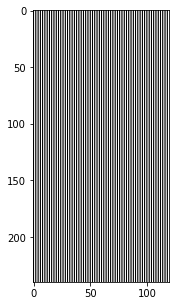

In [ ]:
# show on your masks and assure that they are correct
model.visualize_masks()

In [ ]:
# you have to choose these parameters by yourself
BATCH_SIZE = 1000
EPOCHS = 5
LR = 0.01
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, device=device)

assert test_losses[-1] < 4.0

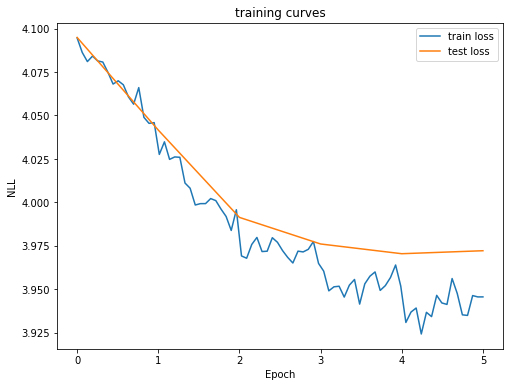

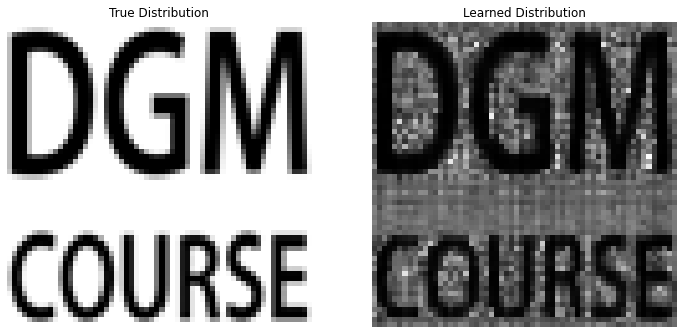

In [ ]:
distribution = get_distribution(model, device=device)
assert distribution.shape == (BINS, BINS)

plot_training_curves(train_losses, test_losses)
plot_2d_distribution(image, distribution)

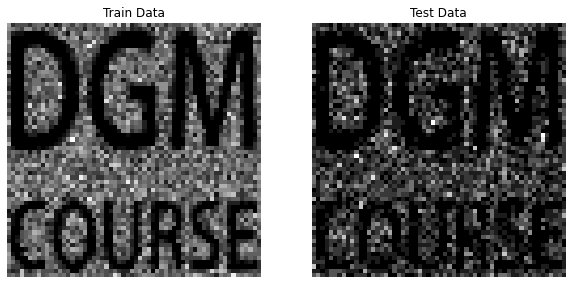

In [ ]:
# draw samples from model 

samples = model.sample(5000)
plot_2d_data(train_data, samples)

## Task 3 (5 points): MADE on MNIST


You do not have to change this functions (except the path to the data file, download it from here: https://drive.google.com/file/d/1Ms-RBybrueI3_w2CRj7lM9mYjfvFRL6w/view?usp=sharing

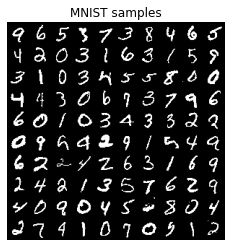

In [ ]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data = data['train'].astype('float32')[:, :, :, 0] > 128
    test_data = data['test'].astype('float32')[:, :, :, 0] > 128
    train_data = train_data.astype('uint8').reshape(-1, 28 * 28)
    test_data = test_data.astype('uint8').reshape(-1, 28 * 28)
    return train_data, test_data


def show_samples(samples, title, nrow=10):
    samples = torch.FloatTensor(samples).reshape(-1, 28, 28)
    samples = torch.unsqueeze(samples, axis=1)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def visualize_data(data, title):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title)

# change the path to the file
train_data, test_data = load_pickle('mnist.pkl')
visualize_data(train_data, 'MNIST samples')

In [ ]:
HIDDEN_SIZES = [512, 512]

model = MADE(28 * 28, 2, HIDDEN_SIZES)
assert [10, 2, 28 * 28] == list(model(torch.randint(0, 2, (10, 28 * 28))).size())

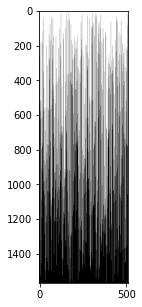

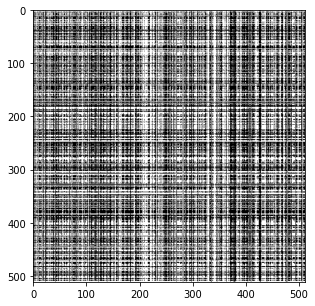

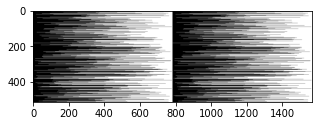

In [ ]:
# show on your masks and assure that they are correct
model.visualize_masks()

In [ ]:
train_data = torch.LongTensor(train_data)
test_data = torch.LongTensor(test_data)

In [ ]:
# you have to choose these parameters by yourself
BATCH_SIZE = 1000
EPOCHS = 15
LR = 0.005
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, lr=LR, device=device)

assert test_losses[-1] < 0.22

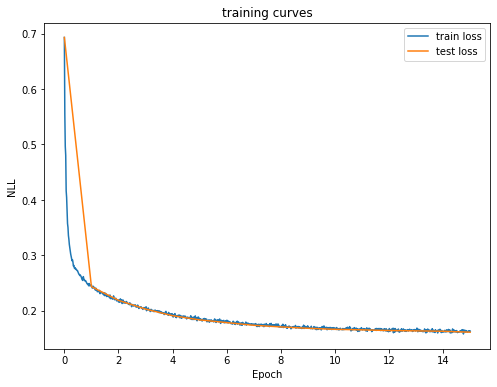

In [ ]:
plot_training_curves(train_losses, test_losses)

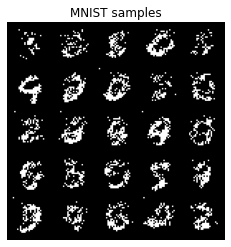

In [ ]:
samples = model.sample(25, device=torch.device('cpu'))
show_samples(samples, title='MNIST samples', nrow=5)